## Extractive Summarization Inference 

In this notebook we will 

- Load a pretrained Pytorch model for **extractive** summarization 
- Perform inference and visualize sentence scores.
- Build a simple pipleline for **abstractive** summarization using HuggingFace transformers
- Load live news articles from [TechCrunch](https://techcrunch.com/) and summarize them using both our extractive and abstractive model .

In [1]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
!pip install -q transformers  rouge-score sentence-transformers

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
 
import plotly.express as px

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
from transformers import AutoTokenizer, AutoModel 
nlp = spacy.load('en_core_web_lg')

In [4]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [5]:
#model path .. modify to location of trained model file 
model_path = "/kaggle/input/models/minilm_bal_exsum.pth"

In [6]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

extractive_model = SentenceBertClass() 
extractive_model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
extractive_model.eval(); 

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/66.4M [00:00<?, ?B/s]

## Extractive Summarization Inference 



In [7]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
# get predictions given some an array of sentences and their corresponding documents
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [9]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences


In [10]:
article = """ Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have further evolved for swimming. Birds are feathered theropod dinosaurs and constitute the only known living dinosaurs. Likewise, birds are considered reptiles in the modern cladistic sense of the term, and their closest living relatives are the crocodilians. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture. Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators. The vast majority of bird species are socially (but not necessarily sexually) monogamous, usually for one breeding season at a time, sometimes for years, but rarely for life. Other species have breeding systems that are polygynous (one male with many females) or, rarely, polyandrous (one female with many males). Birds produce offspring by laying eggs which are fertilised through sexual reproduction. They are usually laid in a nest and incubated by the parents. Most birds have an extended period of parental care after hatching. Many species of birds are economically important as food for human consumption and raw material in manufacturing, with domesticated and undomesticated birds being important sources of eggs, meat, and feathers. Songbirds, parrots, and other species are popular as pets. Guano (bird excrement) is harvested for use as a fertiliser. Birds figure throughout human culture. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them. Recreational birdwatching is an important part of the ecotourism industry. """

In [11]:
article

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have furt

## Inference - Generate Extractive Summary

- Perform inference
- Make sense of model results by visualizing scores assigned to each sentence.

In [12]:
summary, scores, sentences = summarize(article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)
summary

  0%|          | 0/5 [00:00<?, ?it/s]

'Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then.'

Among them were Navy medic Max Soviak, and Marines Hunter Lopez, Rylee McCollum, David Lee Espinoza, Kareem Nikoui, Jared Schmitz, Ryan Knauss, Daegan Page, Taylor Hoover and an unnamed special forces soldier. McCollum's wrestling coach and a close family friend told DailyMail.com that 'heads should roll' over the debacle. McCollum was named by his high school in Wyoming while Espinoza, 20, was named by the local police department in Laredo, Texas, where he was born.

## Visualize Scores Assigned to Each Sentence  

A visualization of the scores assigned by the model can help us "make sense" of model behaviour. 

- is the model weighting each sentence equally or focusing on some sentences? (ideally, we want to see good variation). 


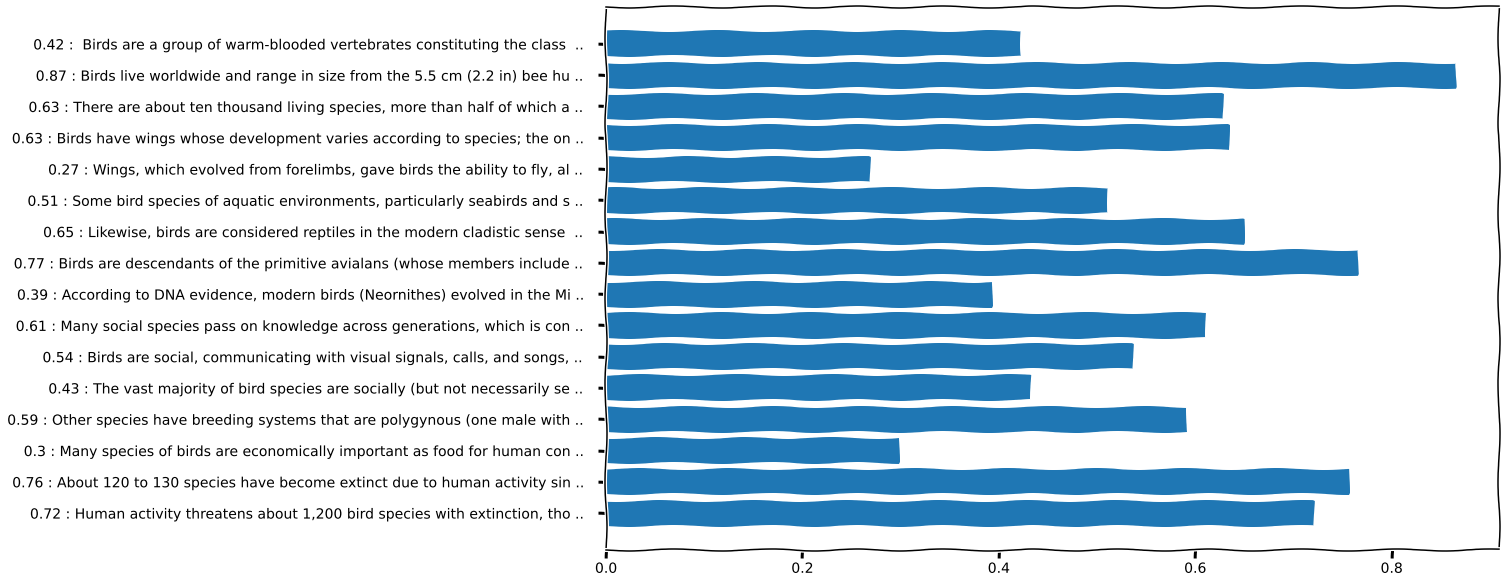

In [13]:
sent_lenth = 70
score_vals = ([x[0] for x in scores] ) 
sub_sents = [ str(round(score_vals[i],2)) + " : " + sentences[i][:sent_lenth] + " ..  " for i in range(len(sentences))] 
with plt.xkcd():
    plt.figure(figsize=(16,10));
    plt.barh(sub_sents[::-1], score_vals[::-1]);

## Scrape some Tech News and Summarize 

- Get a list of articles on front page of TechCrunch news
- Get each article's title, and content using urlib and beatifulsoup.

In [14]:
from bs4 import BeautifulSoup
import urllib.request

import json

def save_json(data, file_path): 
  with open(file_path, 'w', encoding='utf-8') as f:
      json.dump(data, f, ensure_ascii=False, indent=4)

In [15]:
def get_article(page_url):
  page =  urllib.request.urlopen(page_url)
  soup = BeautifulSoup(page, "html.parser")
  content = soup.find("div", attrs={"class": "article-content"})
  content = content.text.replace("\n","").replace("\xa0","").strip()
  return content

main_page =  urllib.request.urlopen("https://techcrunch.com/")
articles = BeautifulSoup(main_page, "html.parser")
articles = articles.find("div", attrs={"id": "root"}).find_all("a", attrs={"class": "post-block__title__link"})

article_contents = [ get_article(x["href"]) for x in articles] 
article_titles = [ x.text.replace("\t","").strip() for x in articles] 

## Abstractive Summarization with HF for Comparison

In [16]:
from transformers import pipeline
from tqdm import tqdm
ab_summarizer = pipeline("summarization", model="t5-base")
import re 


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

2023-01-17 20:49:15.773140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 20:49:15.774175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 20:49:15.775401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 20:49:15.776204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 20:49:15.776952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [17]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

abs_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
abs_tokenizer = AutoTokenizer.from_pretrained("t5-base")



In [18]:
def abstractive_summarize(doc,  max_length=250, min_length=50, batch_size=2):
  all_sum=[]
  # batched prediction
  for i in tqdm(range(int(len(doc) / batch_size) + 1)): 
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)
    batch = ["summarize: " + x for x in doc[batch_start: batch_end]]   
    if (batch):
      inputs = abs_tokenizer.batch_encode_plus( batch, return_tensors="pt", max_length=512, truncation=True, padding=True) 
      outputs = abs_model.generate(inputs["input_ids"], max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
      output = [re.sub(r'<([^>]*)>', "", abs_tokenizer.decode(x))  for x in outputs.tolist()]  
      all_sum = all_sum + output 
  return all_sum

In [19]:
ab_summary = abstractive_summarize(article_contents)

100%|██████████| 12/12 [04:35<00:00, 22.96s/it]


In [20]:
 (ab_summary)

[' the chipsets — the M2 Pro and M2 Max — feature a more powerful CPU and GPU, up to 96 GB of unified memory and what apple claims is “industry-leading” power efficiency. the 10- or 12-core CPU has up to eight high-performance cores and four high-efficiency cores, resulting in multithreaded CPU performance that’s 20% faster than the 10-core CPU in M1 Pro.',
 ' the chipsets — the M2 Pro and M2 Max — feature a more powerful CPU and GPU, up to 96 GB of unified memory and what apple claims is “industry-leading” power efficiency. the 10- or 12-core CPU has up to eight high-performance cores and four high-efficiency cores, resulting in multithreaded CPU performance that’s 20% faster than the 10-core CPU in M1 Pro.',
 " john avlon: 2022 saw fewer exits and venture deals than 2021. avlon: if we had to retain only one fact, it would be the decline in capital invested in startups. avlon: deal count was more stable, with 2022's estimated deal count approaching 2021. avlon: if we had to retain one

In [21]:
ex_summary =  [summarize(x, extractive_model)[0] for x in article_contents ]

100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


In [22]:
ex_summary

['Apple claims that compiling in Xcode is up to 2.5x faster using the M2 Pro than on the fastest Intel-based MacBook Pro, while graphics speeds are up to 30% faster than the M1 Pro Graphics speeds climb up to 30% faster than M1 Max, Apple says. And in terms of battery life, the company claims the M2 Max can deliver up to 22 hours — the longest battery life ever in a Mac.',
 'Apple claims that compiling in Xcode is up to 2.5x faster using the M2 Pro than on the fastest Intel-based MacBook Pro, while graphics speeds are up to 30% faster than the M1 Pro Graphics speeds climb up to 30% faster than M1 Max, Apple says. And in terms of battery life, the company claims the M2 Max can deliver up to 22 hours — the longest battery life ever in a Mac.',
 'If we had to retain only one fact, it would be the decline in capital invested in startups last year. According to CB Insights, whose State of Venture report is one of our sources today, total venture funding in 2022 amounted to $415.1 billion, 3

In [23]:
all_sum = [ {"title": article_titles[i], "content": article_contents[i], "abstractive": ab_summary[i], "extractive": ex_summary[i]} for i in range(len(article_contents))]
save_json(all_sum,"samples.json")

In [24]:
df = pd.DataFrame.from_dict(all_sum)
df

,title,content,abstractive,extractive
0,"Apple unveils M2 Pro and M2 Max chips, featuri...",Apple this morning announced new MacBooks powe...,the chipsets — the M2 Pro and M2 Max — featur...,Apple claims that compiling in Xcode is up to ...
1,,Apple this morning announced new MacBooks powe...,the chipsets — the M2 Pro and M2 Max — featur...,Apple claims that compiling in Xcode is up to ...
2,Putting numbers on the global venture slowdown,"“Tell me something I don’t know,” was my first...",john avlon: 2022 saw fewer exits and venture ...,"If we had to retain only one fact, it would be..."
3,Oversight Board presses Meta to revise ‘convol...,"Meta’s Oversight Board, which independently ev...","the decision concerned two people who, as par...",The case represents a failure of a convoluted ...
4,HBO’s ‘The Last of Us’ gets a warm welcome wit...,“The Last of Us” made its debut last night on ...,the series premiere garnered 4.7 million view...,"Plus, the HBO Max app reached #4 on the overal..."
5,Delphia co-founder placed on leave after sexua...,"Delphia, a mobile investment platform, is faci...","the complaint alleges that on August 17, 2022...","Delphia, a mobile investment platform, is faci..."
6,UK privacy watchdog silent as Google flicks of...,Late last week it emerged Google intends to ig...,google intends to ignore a call by the world ...,Topics refers to an ad-targeting component of ...
7,"Twitter rivals, unicorn trivia and valuation h...","Welcome back toEquity, the podcast about the b...",this week's episode of the podcast is about t...,"It’s Tuesday, not Monday, but hey, the week ah..."
8,2022 global smartphone shipments were the lowe...,One of these days I’ll have some positive news...,the industry capped off another dismal year w...,The industry capped off another dismal year wi...
9,Web3 developer activity spiked in Q4 2022 desp...,Web3 developer activity still grew in the last...,the global market capitalization of the crypt...,Web3 developer activity still grew in the last...
